### Background of program
We try to create a linear regression model to study insurance premiums.

### Basic configuration steps

We import some standard packages to do this task. In addition, some bespoke functions have been created to help serve other purposes.


In [1]:
# - import basic python packages
import warnings
import tkinter  # to show plot in Pycharm

warnings.simplefilter(action='ignore', category=FutureWarning)

# - import packages for data manipulations
import numpy as np
import pandas as pd

# - import packages for visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as FF
import pylab
import plotly
import plotly.io as pio
pio.renderers.default = "svg"

# - import packages for statistical analyses
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import zscore, probplot
from scipy.stats import skew, kurtosis
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from statsmodels.stats.stattools import durbin_watson
from statsmodels.nonparametric.smoothers_lowess import lowess

# - import packages for building of linear models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, lars_path
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# - packages created
from utils import var_bracket

# - configure the setting to display all columns
pd.set_option('display.max_columns', None)


###   Read CSV data file

The insurance dataset contains 1,338 observations; there are 7 features. We aim to look into different features to observe their relationship, plot multiple linear regression based on several features of individual e.g. age, physical / family condition and location against their existing medical expense to be used for predicting future medical expenses of individuals that help medical insurance to make decision on charging premiums.

In [2]:
insurance_df = pd.read_csv('insurance.csv')
print("We look at a sample of the data: \n", insurance_df.head())
print("We also look at some additional data information: \n", insurance_df.info())
print("Next we try to count the instances of missing values (if any): \n", insurance_df.isnull().sum())

We look at a sample of the data: 
    age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
We also look at some additional data information: 
 None
Next we try to count the instances

###   perform basic statistical checks and generate statistical metrics (e.g. skew, kurtosis) to make basic analyses

- skewness: a measure of asymmetry of a distribution; value be positive (right-skewed) or negative (left-skewed) any values of skewness between -0.5 and 0.5 is considered as being fairly symmetrical
- kurtosis: a measure of whether or not a distribution is heavy-tailed or light-tailed. For reference, kurtosis of a normal distribution is 3. A distribution with kurtosis less than 3 is said to produce fewer and less extreme outliers than the normal distribution; more than 3 means more outliers than the normal distance. A negative kurtosis means that the distribution is flatter than a normal curve with same mean and standard deviation.

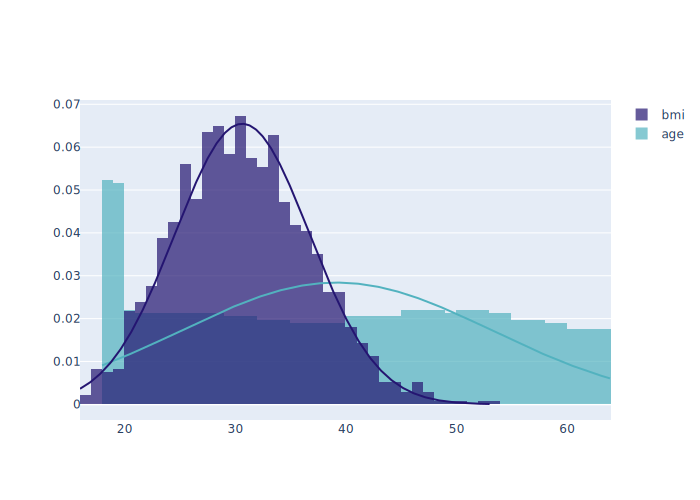

We print the results of skewness and kurtosis:

skewness of age is 0.05567
kurtosis of age is -1.24509
skewness of bmi is 0.28459
kurtosis of bmi is -0.05337


In [3]:
# - statistical metrics (skew, kurtosis) of the numerical data ("age", "bmi")
numerical_vars = ["age", "bmi"]
data_vars = [insurance_df[col].to_list() for col in
             numerical_vars]  # list of variable values (in a list); list of lists

fig1 = FF.create_distplot(data_vars, group_labels=numerical_vars, bin_size=[1, 1], colors=["#52B2BF", "#241571"],
                          curve_type="normal", show_rug=False)
fig1.show()

print("We print the results of skewness and kurtosis:\n")
for col in numerical_vars:
    print("skewness of", col, "is", round(skew(insurance_df[col], bias=False), 5))
    print("kurtosis of", col, "is", round(kurtosis(insurance_df[col], bias=False), 5))

We see that the "age" data is very right-skewed, "bmi" on the other hand is quite balanced the parameter "bias = False" calculates for sample rather than for population judging from the "kurtosis" values, we note that the distributions of the "age" and "bmi" data are flatter than that
of a normal distribution curve.

### Feature engineering

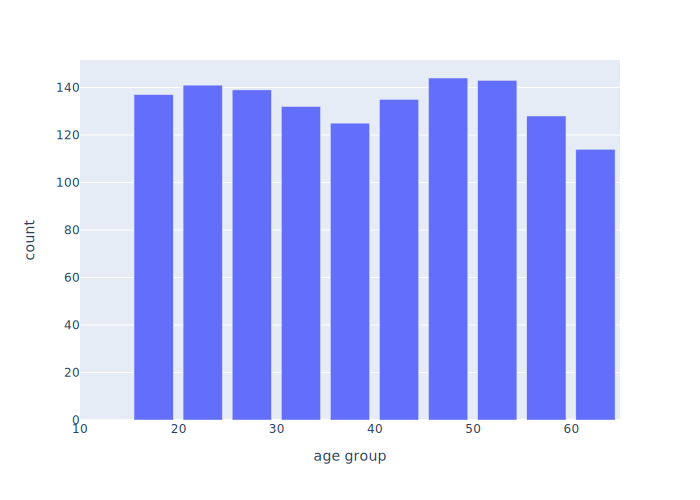

In [4]:
# - we plot a histogram and then determine how we can create a feature to group ages into 'buckets'
counts, bins = np.histogram(insurance_df.age, bins=range(10, 70, 5))
bins = 0.5 * (bins[:-1] + bins[1:])

fig2 = px.bar(x=bins, y=counts, labels={'x': 'age group', 'y': 'count'})
fig2.show()

In [5]:
# - we create a feature to provide information on the percentile rank of the 'age' column
insurance_df['age_pct_rank'] = round(insurance_df['age'].rank(pct=True) * 100)
insurance_df['age_bracket'] = insurance_df.age_pct_rank.apply(
    lambda x: var_bracket(insurance_df, "age_pct_rank", "age", x))

# - we create a feature to provide information on the percentile rank of the 'age' column
insurance_df['bmi_pct_rank'] = round(insurance_df['bmi'].rank(pct=True) * 100)
insurance_df['bmi_bracket'] = insurance_df["bmi_pct_rank"].apply(
    lambda x: var_bracket(insurance_df, "bmi_pct_rank", "bmi", x))

Given that "age" is highly skewed, we scale the age variable.

In regression, it is often recommended to center the variables so that the independent variables have mean "0" for easier interpretation. However, in general it is not necessary to center or standardize your data for multiple regression; different variables can be on different scales (i.e. in different units) and this is not a problem.

In [6]:
std_scaler = StandardScaler()
insurance_df["age_scaled"] = std_scaler.fit_transform(insurance_df[["age"]])
insurance_df["bmi_scaled"] = std_scaler.fit_transform(insurance_df[["bmi"]])

We relook again at the histogram

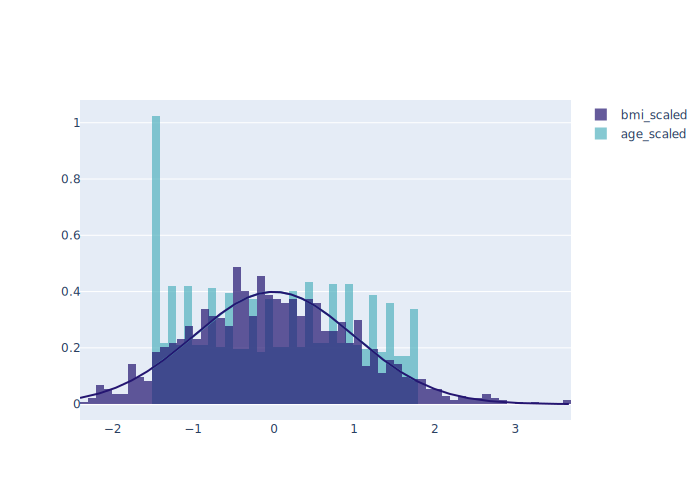

In [7]:
numerical_vars2 = ["age_scaled", "bmi_scaled"]
data_vars2 = [insurance_df[col].to_list() for col in
              numerical_vars2]  # list of variable values (in a list); list of lists

fig3 = FF.create_distplot(data_vars2, group_labels=numerical_vars2, bin_size=[0.1, 0.1], colors=["#52B2BF", "#241571"],
                          curve_type="normal", show_rug=False)
fig3.show()

###   Basic exploration data analysis


We try to identify outliers (of the numerical variables) using Boxplot: "age", "bmi", "children" against "expenses" using boxplots.

A box plot is a stats representation of the distribution of a variable through its quartiles. The ends of the box represents the lower (Q1, 25th percentile) and upper quartiles (Q3, 75th percentile), while the median (Q2, 50th percentile) is marked by a line inside the box. Length of box shows the length of IQR.

The 'whiskers' define the min and max values (both excluding outliers); outliers lay outside the whiskers. Outliers are points that lie outside the lower quartile (Q1) or the upper quartile (Q3) by 1.5 * IQR
- Q1 - (1.5 * IQR)
- Q3 + (1.5 * IQR)

We delete outliers only when the data is clearly wrong (e.g. age is "200" and when you have a lot of data). We do not delete outliers if the results are critical (e.g. in risk modelling of anomaly detection cases) and if there are a lot of outliers, i.e. the outliers are not as rare as we know them to be (e.g. 30% of the data are outliers). We could further analyse results on whether results change with / without outliers (e.g. are outliers skewing statistical relationships, or whether outliers create false relationships).

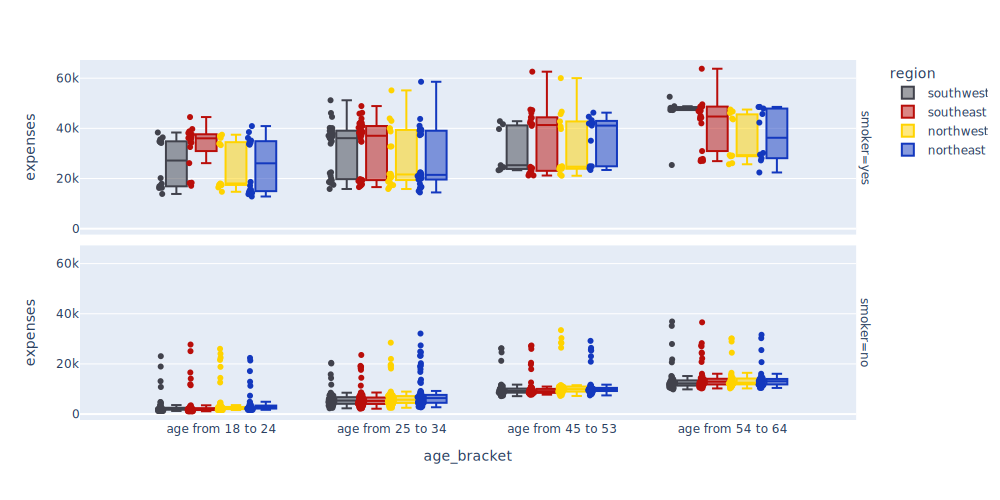

In [8]:
# --- sub-plots for age (numerical vars) against expenses, coloured with each categorical variables (sex, smoker, region)
categorical_vars = ["sex", "smoker", "region"]
colors_sex = ["#FC46AA", "#1338BE"]
colors_region = ["#41424C", "#B90E0A", "#FFD300", "#1338BE"]
colors_smoker = ["#710C04", "#0492C2"]

# - we plot box plot with "age_bracket" against, split by "region" with "smoker" as the facet
fig5a = px.box(insurance_df, x="age_bracket", y="expenses", points="all",
               color="region", color_discrete_sequence=colors_region, facet_row="smoker",
               category_orders={"age_bracket": sorted(list(set(insurance_df.age_bracket.values)))})

fig5a.show(width = 1000)

We observe that "non-smokers" have many outliers across all age bracket groups; we question if the burden of medical costs has been transferred to those who "non-smokers" who have gotten insurance non-smokers are charged roughly the same price across all age bracket groups, except for quite a few outliers even so, the median expense paid by "smokers" is several times that of "non-smokers" regardless of region "smokers" also seem to be paying quite disparate prices, evident from the spread of the "boxes" of the box plots an anomaly seen is that the spread of the data is quite low under the oldest age category for the "southwest" region
and another anomaly is that the spread of the data is quite low under the youngest age category for "southeast" region/


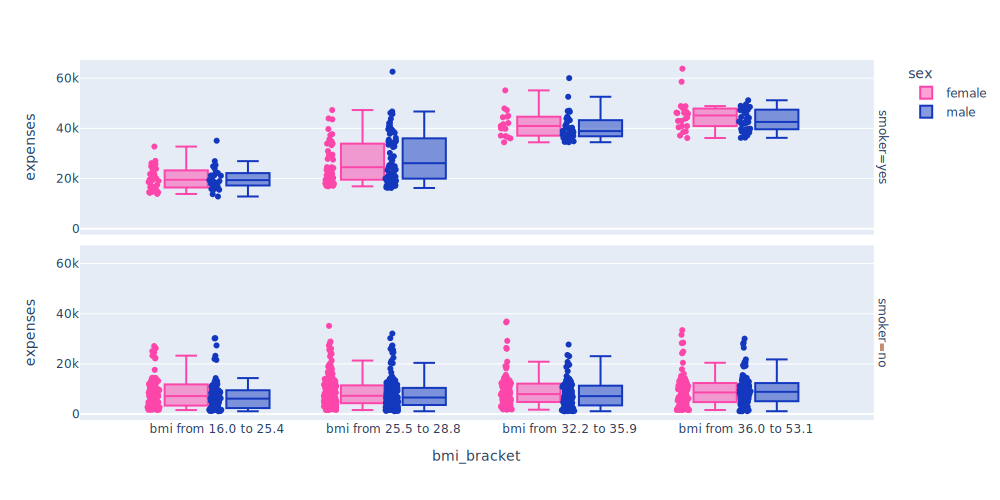

In [9]:
# - we plot box plot with "bmi_bracket" against, split by "sex" with "smoker" as the facet
fig5b = px.box(insurance_df, x="bmi_bracket", y="expenses", points="all",
               color="sex", color_discrete_sequence=colors_sex, facet_row="smoker",
               category_orders={"bmi_bracket": sorted(list(set(insurance_df.bmi_bracket.values)))})

fig5b.show(width = 1000)

We observe that "non-smokers" pay almost the same price all BMI bracket group "smokers" can pay up to 4 times more premium than "non-smokers". "smokers" in the last two BMI groups (32.2 to 35.9 and 36 to 53.1) pay double than what the second highest BMI group (25.5 to 28.8) pay.

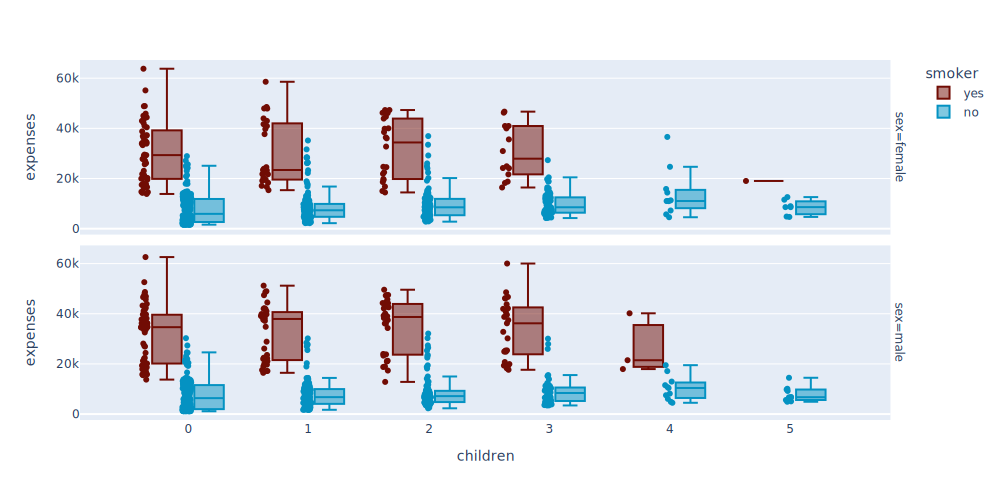

In [10]:
# - we plot box plot with "age_bracket" against, split by "smoker" with "smoker" as the facet
fig5c = px.box(insurance_df, x="children", y="expenses", points="all",
               color="smoker", color_discrete_sequence=colors_smoker, facet_row="sex",
               category_orders={"children": sorted(list(set(insurance_df.children.values)))})

fig5c.show(width = 1000)

Female and male "non-smokers" generally pay about the same expenses across the "number of children" category female "smokers" are generally paying lower expenses than its male "smokers" counterparts across all categories we do not see a lot of "smokers" having at least four children.

**Create a correlation heatmap to check for correlation between variables**

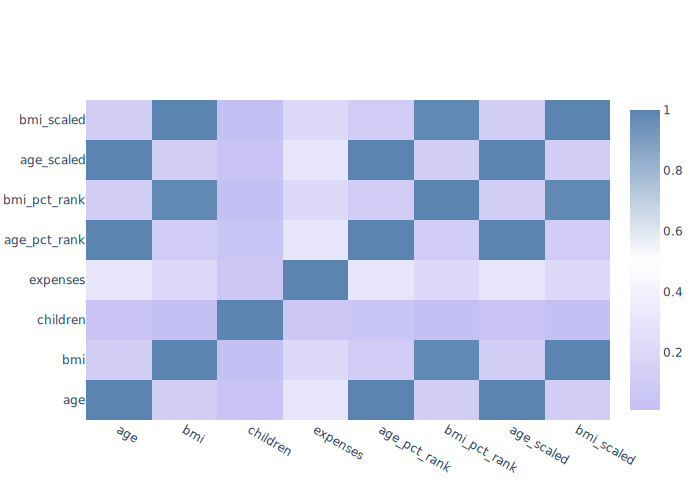

In [11]:
correlation_df = insurance_df.corr()
colorscale4 = [[0, "#C5C0F3"], [0.5, "white"], [1, "#5B84B1"]]

trace4 = go.Heatmap(z=correlation_df.values, x=correlation_df.index.values, y=correlation_df.columns.values,
                    colorscale=colorscale4)
fig6 = go.Figure(data=trace4)

fig6.show()

Apart from the percentile rank columns that are engineered from (and hence correlated with) the "age" and "bmi" variables, the other variables are not poorly correlated (no uncorrelated variables).

### Build and evaluate the multiple linear regression model

In [12]:
# - consolidate the engineered variables that we will drop
engineered_vars = [col for col in insurance_df.columns if "bracket" in col]

# - perform one-hot encoding for the categorical variables; identify the independent and dependent variables
X1 = insurance_df.drop(["expenses"] + categorical_vars + engineered_vars, axis=1)
X2 = pd.get_dummies(insurance_df.loc[:, categorical_vars])
X = pd.concat([X1, X2], axis=1)
y = insurance_df.expenses
df = pd.concat([X, y], axis=1)  # concatenate the dataframes for the OLS model

# - we create the OLS model where we can perform interaction of terms
ols_formula = "expenses ~ age + bmi + sex + smoker + children + region + age_pct_rank + " \
              "bmi_pct_rank + age_bracket + bmi_bracket"

ols_model = smf.ols(formula=ols_formula, data=insurance_df).fit()

# - generate the fitted values and residuals
ols_fitted_y = ols_model.fittedvalues
ols_resids = ols_model.resid

In [13]:
# - summary statistics (including model evaluation metrics e.g. R-squared and adjusted R-squared)
print(ols_model.summary())  # use "dir(ols_model)" to see all of the attributes
print("R-squared score for the model: ", ols_model.rsquared)  # 0.758
print("Adjusted R-squared score for the model", ols_model.rsquared_adj)  # 0.755

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     258.5
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:18:57   Log-Likelihood:                -13529.
No. Observations:                1338   AIC:                         2.709e+04
Df Residuals:                    1321   BIC:                         2.718e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


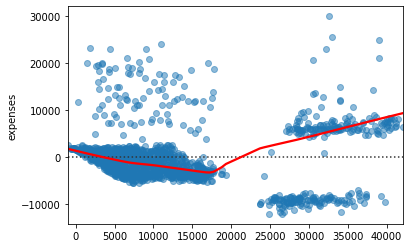

In [14]:
# - plot the residuals plot using the fitted values
fig7 = plt.figure()
fig7.axes[0] = sns.residplot(x=ols_fitted_y, y=df.columns[-1], data=df, lowess=True,
                             scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})


We note that the residuals has some pattern that appear like 3rd degree polynomial; we attempt to perform polynomial regression where the relationship between the independent variable and the dependent variable is modelled as a 3rd degree polynomial (nonlinear relationship) in the independent variables; polynomial regression is considered to be a special case of multiple linear regression.

### Build the polynomial regression model
Build the polynomial OLS (involves two steps: convert features into a polynomial, and build the OLS). The OLS syntax has a "maximum recursion" constraint, we add these variables as standalone variables.

In [15]:
var = ["sex", "smoker", "children", "region", "age_pct_rank", "bmi_pct_rank"]
results_deg1 = ' + '.join(i for i in var)
results_deg2 = ' + '.join(i + "*" + j for i in var for j in var)
results_deg3 = ' + '.join(i + "*" + j + "*" + k for i in var for j in var for k in var)
add_vars = ' + '.join(["age", "bmi", "age_pct_rank**5", "region**5", "smoker**5", "bmi_pct_rank**5", "children**5"])

poly_ols_formula = "expenses ~ " + results_deg1 + " + " + results_deg2 + " + " + results_deg3 + " + " + add_vars
poly_ols_model = smf.ols(formula=poly_ols_formula, data=insurance_df).fit()

# - generate the fitted values and residuals
poly_ols_fitted = poly_ols_model.fittedvalues
poly_ols_resids = poly_ols_model.residvar = ["sex", "smoker", "children", "region", "age_pct_rank", "bmi_pct_rank"]
results_deg1 = ' + '.join(i for i in var)
results_deg2 = ' + '.join(i + "*" + j for i in var for j in var)
results_deg3 = ' + '.join(i + "*" + j + "*" + k for i in var for j in var for k in var)
add_vars = ' + '.join(["age", "bmi", "age_pct_rank**5", "region**5", "smoker**5", "bmi_pct_rank**5", "children**5"])

poly_ols_formula = "expenses ~ " + results_deg1 + " + " + results_deg2 + " + " + results_deg3 + " + " + add_vars
poly_ols_model = smf.ols(formula=poly_ols_formula, data=insurance_df).fit()

# - generate the fitted values and residuals
poly_ols_fitted = poly_ols_model.fittedvalues
poly_ols_resids = poly_ols_model.resid

In [16]:
# - summary statistics (including model evaluation metrics e.g. R-squared and adjusted R-squared)
print(poly_ols_model.summary())  # use "dir(ols_model)" to see all of the attributes

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     102.2
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:18:59   Log-Likelihood:                -13169.
No. Observations:                1338   AIC:                         2.649e+04
Df Residuals:                    1262   BIC:                         2.688e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### Model evaluation (R-squared, adjusted R-squared)

R-squared is a goodness-of-fit measure for linear regression that represents the proportion of the variance for a dependent variable that is explained by an independent variable/variables in a regression model. If the R-squared of a model is 0.50, then about half of the observed variation can be explained by the model's inputs; high R-squared does not mean having good models there is no standard gauge as to how high R-squared needs to be. Different research questions have different amounts of variability that are inherently unexplainable R-squared favours complexity in a model; regression models with many independent variables has higher R-squared values.

In [17]:
print("R-squared score for the model: ", poly_ols_model.rsquared)  # improvement to "0.858", up from "0.758"
print("Adjusted R-squared score for the model", poly_ols_model.rsquared_adj)  # improvement to "0.850", up from "0.755"

R-squared score for the model:  0.8586492264500752
Adjusted R-squared score for the model 0.8502488239015457


###   Checking if some of the assumptions of a linear model are violated

**1. residuals plot has a linear pattern in the data (flat LOWESS [locally weighted scatterplot smoothing] line)**

We plot the residuals plot using the fitted values (and we annotate the top 3 outlier observations)reference to Jason Sadowski's article (https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a).

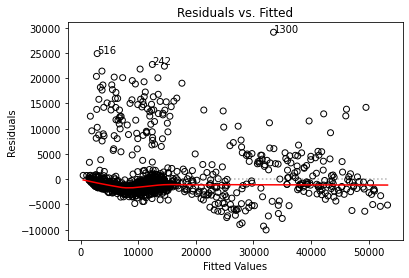

In [18]:
smoothed = lowess(poly_ols_resids, poly_ols_fitted)
top3 = abs(poly_ols_resids).sort_values(ascending=False)[:3]

fig, ax = plt.subplots()
ax.scatter(poly_ols_fitted, poly_ols_resids, edgecolors='k', facecolors='none')
ax.plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(poly_ols_fitted), max(poly_ols_fitted)], [0, 0], color='k', linestyle=':', alpha=.3)

for i in top3.index:
    ax.annotate(i, xy=(poly_ols_fitted[i], poly_ols_resids[i]))

plt.show()


**2. homoscedasticity of the residuals**

Judging from the residuals plot we see that there is no discernible pattern in the residuals that signal heteroscedasticity.

**3. correlation of residuals**

Based on the autocorrelation function (ACF) plot, we see that there is no correlation of error terms

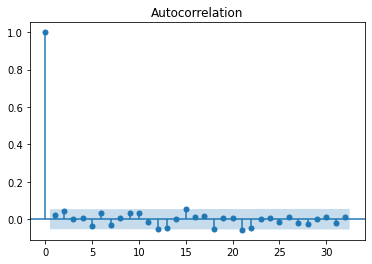

In [19]:
fig8c = sm.graphics.tsa.plot_acf(poly_ols_fitted)

**4. Dublin-Watson Test**

Dublin-Watson Test allows the means to detect residual correlation; if the "d statistic" is around 2, residuals are uncorrelated.

In [20]:
print("Dublin-Watson test: ", durbin_watson(poly_ols_model.resid))

Dublin-Watson test:  2.033310537226476
